In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import importlib

import torch
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

from datasets.hdf5 import get_train_loaders
from unet3d.config import load_config
from unet3d.losses import get_loss_criterion
from unet3d.metrics import get_evaluation_metric
from unet3d.model import get_model
from unet3d.trainer import UNet3DTrainer
from unet3d.utils import get_logger
from unet3d.utils import get_number_of_learnable_parameters

import argparse

import os
import yaml
import numpy as np
import h5py
import matplotlib.pyplot as plt
import ipyvolume as ipv

import time

In [3]:
def show_figure(data, xs, ys, zs):
    sphere_size = 5
    # Make sure to convert list of coordinates to
    # _float_ array otherwise it won't work.
    xs = np.asarray(xs, dtype='float32')
    ys = np.asarray(ys, dtype='float32')
    zs = np.asarray(zs, dtype='float32')
    ipv.figure()
    ipv.volshow(data)
    ipv.scatter(xs, ys, zs, marker='sphere', color='yellow', size=sphere_size)
    #ipv.xyzlim(0, 50)
    ipv.show()

# load model for predction

In [4]:
config_file = 'resources/train_config_ce.yaml'
config = yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader)
model = get_model(config)
loaded_model = torch.load('3dunet/last_checkpoint.pytorch')
model.load_state_dict(loaded_model['model_state_dict'])
model.eval() 

UNet3D(
  (encoders): ModuleList(
    (0): Encoder(
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (conv): Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace)
          (groupnorm): GroupNorm(8, 16, eps=1e-05, affine=True)
        )
        (SingleConv2): SingleConv(
          (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace)
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
        )
      )
    )
    (1): Encoder(
      (pooling): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
      (basic_module): DoubleConv(
        (SingleConv1): SingleConv(
          (conv): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          (ReLU): ReLU(inplace)
          (groupnorm): GroupNorm(8, 32, eps=1e-05, affine=True)
        )
   

### load training and test sets using a data loader

In [5]:
# Create data loaders
loaders = get_train_loaders(config)

2019-08-07 23:05:26,697 [MainThread] INFO HDF5Dataset - Creating training and validation set loaders...
2019-08-07 23:05:26,699 [MainThread] INFO HDF5Dataset - Slice builder class: SliceBuilder
2019-08-07 23:05:26,699 [MainThread] INFO HDF5Dataset - Loading training set from: ../h5_fractals/0.h5...
2019-08-07 23:05:26,820 [MainThread] INFO HDF5Dataset - Loading training set from: ../h5_fractals/1.h5...
2019-08-07 23:05:26,934 [MainThread] INFO HDF5Dataset - Loading training set from: ../h5_fractals/2.h5...
2019-08-07 23:05:27,049 [MainThread] INFO HDF5Dataset - Loading training set from: ../h5_fractals/3.h5...
2019-08-07 23:05:27,166 [MainThread] INFO HDF5Dataset - Loading training set from: ../h5_fractals/4.h5...
2019-08-07 23:05:27,285 [MainThread] INFO HDF5Dataset - Loading training set from: ../h5_fractals/5.h5...
2019-08-07 23:05:27,401 [MainThread] INFO HDF5Dataset - Loading training set from: ../h5_fractals/6.h5...
2019-08-07 23:05:27,515 [MainThread] INFO HDF5Dataset - Loading 

In [6]:
image,label = next(iter(loaders['train']))
val_image, val_label = next(iter(loaders['val']))

In [7]:
#assert np.all((image == val_image).numpy()), 'test, train images are different'
#assert np.all((label == val_label).numpy()), 'test, train labels are different'

In [8]:
ipv.quickvolshow(val_image[0,0,:,:,:])

/home/gheimber/miniconda3/envs/dev2/lib/python3.7/site-packages/ipyvolume/serialize.py:81: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0]**2 + gradient[1]**2 + gradient[2]**2)


In [9]:
ipv.quickvolshow(val_label[0,:,:,:])

In [10]:
t_start = time.time()
with torch.no_grad():
      output = model(val_image)
print(time.time() - t_start)
prediction_np = output.detach().numpy()


31.38115382194519


In [11]:
ipv.quickvolshow(val_image[0,0,:,:,:].numpy() + prediction_np[0,1,:,:,:])

In [12]:
ipv.quickvolshow(prediction_np[0,1,:,:,:])

In [13]:
image.shape

torch.Size([1, 1, 128, 128, 128])

In [14]:
ipv.quickvolshow(prediction_np[0,1,:,:,:] + val_label[0,:,:,:].numpy())

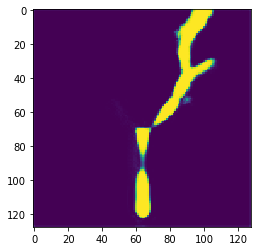

In [15]:
plt.imshow(np.max(prediction_np[0,1,:,:,:], axis=1))

In [16]:
loss_fn = get_loss_criterion(config)
loss_value = loss_fn(output, label)

/home/gheimber/miniconda3/envs/dev2/lib/python3.7/site-packages/torch/nn/modules/module.py:493: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  result = self.forward(*input, **kwargs)


In [17]:
loss_value

tensor(0.3285)

## load pytorch intermediate tensor

In [5]:
a = torch.load('file.pt')

In [15]:
ipv.quickvolshow(a.cpu().detach().numpy()[0,0,:,:,:])